In [1]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Load saved credentials
service = QiskitRuntimeService()

In [2]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import numpy as np
import h5py
from matplotlib import pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Pre-defined ansatz circuit and operator class for Hamiltonian
from qiskit.circuit.library import EfficientSU2
from qiskit.quantum_info import SparsePauliOp

# SciPy minimizer routine
from scipy.optimize import minimize

# Plotting functions
import matplotlib.pyplot as plt

# Hamiltonian
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator, DensityMatrix, entropy, random_density_matrix

# runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import EstimatorV2 as Estimator
import pandas as pd
import numpy as np
from qiskit.synthesis import OneQubitEulerDecomposer
from qiskit.synthesis import TwoQubitBasisDecomposer
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import CXGate
from qiskit.visualization import plot_histogram, plot_bloch_vector

import h5py
import numpy as np
import pylab

from functools import lru_cache
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, ADAM, GradientDescent, SPSA, CG
from qiskit.primitives import StatevectorEstimator as Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer import AerSimulator
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit.converters import circuit_to_dag

import numpy as np
from qiskit.circuit import ParameterVector
from scipy.optimize import minimize
from qiskit.circuit.library import RXXGate, RYYGate, RZZGate, RXGate, TwoLocal

In [3]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

In [225]:
import os
import glob


pattern = "gates_N*_D*.h5"

for filepath in glob.glob(pattern):
    try:
        os.remove(filepath)
        print(f"Removed {filepath}")
    except OSError as e:
        print(f"Error removing {filepath}: {e}")

### Multiple depth circuit

In [226]:
import glob, re
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
import h5py

def load_gates_hdf5(filename):
    gates = {}
    with h5py.File(filename, "r") as file:
        for key in file.keys():
            
            matrix = file[key][:]
            parts = key.split('_')
            gate_str = parts[1] 
            gate_index = int(gate_str.replace("gate", ""))
            
            if matrix.shape == (4,4) and gate_index != 1:
                matrix = np.transpose(matrix)
            
            gates[key] = matrix
            #print(f"{key} loaded with shape {matrix.shape}:\n{matrix}\n")
    return gates

def generate_quantum_circuit_from_dict(gates_dict):
    # 1) Group matrices by layer number and gate index
    layers = {}
    for key, matrix in gates_dict.items():
        layer_str, gate_str = key.split("_")         # e.g. "layer3", "gate2"
        L = int(layer_str.replace("layer", ""))
        G = int(gate_str.replace("gate", ""))
        layers.setdefault(L, {})[G] = matrix

    # 2) Build a list-of-lists: sorted_layers[L_idx] = [mat_gate1, mat_gate2, ...]
    sorted_layers = []
    for L in sorted(layers.keys()):
        # sort gate indices within this layer
        row = [layers[L][g] for g in sorted(layers[L].keys())]
        sorted_layers.append(row)

    # 3) Determine qubit count (gates per layer)
    n = len(sorted_layers[0])
    qc = QuantumCircuit(n)

    # 4) Append gates in layer order
    for L_idx, gate_list in enumerate(sorted_layers, start=1):
        # two-qubit gates on qubits (0,1), (1,2), ..., (n-2,n-1)
        for i, mat in enumerate(gate_list[:-1]):
            qc.append(UnitaryGate(mat, label=f"L{L_idx}G{i+1}"), [i, i+1])
        # single-qubit gate on qubit (n-1)
        qc.append(UnitaryGate(gate_list[-1], label=f"L{L_idx}G{n}"), [n-1])

    return qc

def load_all_tnqc_circuits(n_sites, max_depth=10):
    circuits = {}
    pattern = f"gates_N{n_sites}_D*.h5"
    for fname in sorted(glob.glob(pattern)):
        m = re.match(rf"gates_N{n_sites}_D(\d+)\.h5", fname)
        if not m: 
            continue
        depth = int(m.group(1))
        if 1 <= depth <= max_depth:
            gates = load_gates_hdf5(fname)
            qc = generate_quantum_circuit_from_dict(gates)
            circuits[depth] = qc
            print(f"Loaded depth {depth} → circuit depth {qc.depth()}") 
    return circuits

n_sites = 10
max_depth = 10

circuits_by_depth = load_all_tnqc_circuits(n_sites, max_depth)

Loaded depth 1 → circuit depth 10
Loaded depth 10 → circuit depth 28
Loaded depth 2 → circuit depth 12
Loaded depth 3 → circuit depth 14
Loaded depth 4 → circuit depth 16
Loaded depth 5 → circuit depth 18
Loaded depth 6 → circuit depth 20
Loaded depth 7 → circuit depth 22
Loaded depth 8 → circuit depth 24
Loaded depth 9 → circuit depth 26


The resulting circuit with a depth:  10


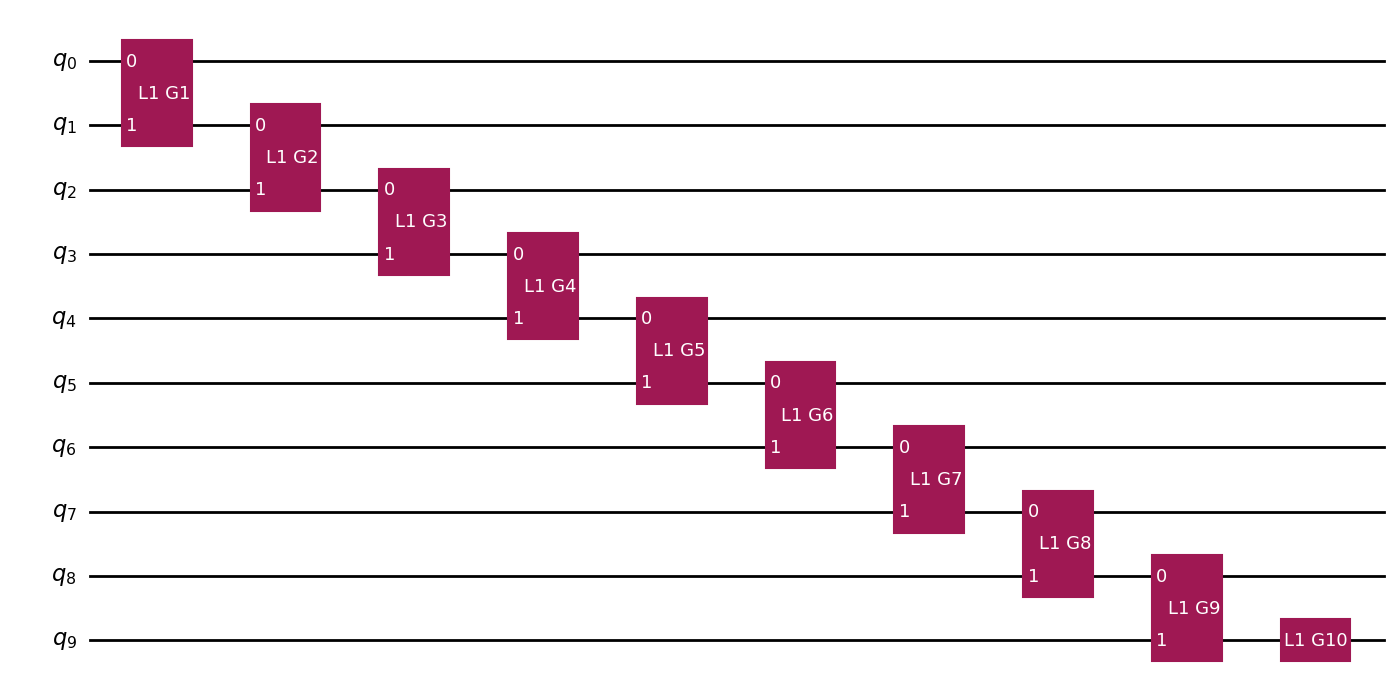

In [227]:
def load_gates_hdf5(filename):
    gates = {}
    with h5py.File(filename, "r") as file:
        for key in file.keys():
            # Load the matrix from file.
            matrix = file[key][:]
            # Parse the key to determine the gate index.
            # Expected key format: "layerX_gateY"
            parts = key.split('_')
            gate_str = parts[1]  # e.g., "gate2"
            gate_index = int(gate_str.replace("gate", ""))
            
            # If it's a two-qubit gate (4x4) and not the first gate, transpose it.
            if matrix.shape == (4,4) and gate_index != 1:
                matrix = np.transpose(matrix)
            
            gates[key] = matrix
            #print(f"{key} loaded with shape {matrix.shape}:\n{matrix}\n")
    return gates

def generate_quantum_circuit_from_dict(gates_dict):
    # Organize gates by layer.
    layers = {}
    for key, matrix in gates_dict.items():
        # key expected to be like "layerX_gateY"
        parts = key.split('_')
        layer_str = parts[0]  # "layerX"
        gate_str  = parts[1]  # "gateY"
        L = int(layer_str.replace("layer", ""))
        G = int(gate_str.replace("gate", ""))
        if L not in layers:
            layers[L] = {}
        layers[L][G] = matrix

    # Sort layers by layer number and sort gates within each layer.
    sorted_layers = {}
    for L in sorted(layers.keys()):
        sorted_layers[L] = [layers[L][g] for g in sorted(layers[L].keys())]

    # Assume the number of qubits is determined by the number of gates in any layer.
    # (Each layer should contain N gates.)
    first_layer = sorted_layers[next(iter(sorted_layers))]
    n = len(first_layer)
    qc = QuantumCircuit(n)

    # For each layer, append the corresponding gates.
    for L in sorted(sorted_layers.keys()):
        gate_list = sorted_layers[L]
        # Append two-qubit gates for indices 0 to n-2.
        for i in range(n - 1):
            gate = UnitaryGate(gate_list[i], label=f"L{L} G{i+1}")
            qc.append(gate, [i, i+1])
        # Append the final gate (one-qubit) on the last qubit.
        gate = UnitaryGate(gate_list[-1], label=f"L{L} G{n}")
        qc.append(gate, [n-1])
   

    return qc

# Example usage:
# Load the multi-layer gates from the HDF5 file for a circuit of N=3 sites and depth D=2.
gates = load_gates_hdf5("gates_N10_D1.h5")

# Generate the quantum circuit from the loaded multi-layer gates.
qc = generate_quantum_circuit_from_dict(gates)
print("The resulting circuit with a depth: ", qc.depth())
qc.draw("mpl")

In [228]:
def build_2d_heisenberg_sparsepauli(Nx: int, Ny: int) -> SparsePauliOp:
    N = Nx * Ny
    labels = []
    coeffs = []

    # helper to append one XX, YY, and ZZ term
    def add_bond(i, j):
        # coefficient 1/4 comes from S = σ/2 
        for pauli_pair in ["XX", "YY", "ZZ"]:
            lab = ["I"] * N
            lab[i] = pauli_pair[0]
            lab[j] = pauli_pair[1]
            labels.append("".join(lab))
            coeffs.append(1/4)

    # loop over all sites and their right/down neighbors
    for y in range(Ny):
        for x in range(Nx):
            idx = y * Nx + x
            # right neighbor
            if x + 1 < Nx:
                add_bond(idx, idx + 1)
            # down neighbor
            if y + 1 < Ny:
                add_bond(idx, idx + Nx)

    return SparsePauliOp(labels, coeffs)

# --- usage example ---
Nx, Ny = 2,5
hamiltonian = build_2d_heisenberg_sparsepauli(Nx, Ny)

In [229]:
state = Statevector(qc)
Energy = state.expectation_value(hamiltonian)
print("Theoretical energy of initial guess:", np.real(Energy))

Theoretical energy of initial guess: -4.47889553709418


In [230]:
numpy_solver = NumPyMinimumEigensolver()
result = numpy_solver.compute_minimum_eigenvalue(operator=hamiltonian)
groundstate_value = result.eigenvalue.real
print(f"groundstate value: {groundstate_value:.5f}")

groundstate value: -5.44671


In [169]:
percentage_error = abs(((groundstate_value - Energy)/groundstate_value) * 100)
print(percentage_error)

21.361246445599814


### Multiple depth varaiational tail

In [179]:
def generate_augmented_circuits(circuits_by_depth, max_p=8):

    augmented = {}
    for D, base_qc in circuits_by_depth.items():
        n_qubits = base_qc.num_qubits

        for p in range(1, max_p + 1):
            # collect parameters for this (D,p) ansatz
            params = []
            tail = QuantumCircuit(n_qubits, name=f"var_D{D}_p{p}")

            # build p layers of the 2q+1q pattern
            for layer_idx in range(p):
                # two-qubit rotations across the chain
                for q in range(n_qubits - 1):
                    for GateClass in (RXXGate, RYYGate, RZZGate):
                        φ = Parameter(f"ϕ_D{D}_p{p}_{len(params)}")
                        params.append(φ)
                        tail.append(GateClass(φ), [q, q+1])
                # single-qubit RX on each qubit
                for q in range(n_qubits):
                    φ = Parameter(f"ϕ_D{D}_p{p}_{len(params)}")
                    params.append(φ)
                    tail.append(RXGate(φ), [q])

            # compose the MPS core + variational tail
            full = base_qc.compose(tail, inplace=False)
            full.name = f"MPS{D}_var{p}"
            augmented[(D, p)] = full

    return augmented

augmented_circuits = generate_augmented_circuits(circuits_by_depth, max_p=8)

#print(f"Total circuits generated: {len(augmented_circuits)}")  

# Inspect one
#D, p = 4, 2
#full_circ = augmented_circuits[(D,p)]
#full_circ.draw("mpl")

### Single Depth Variational Tail

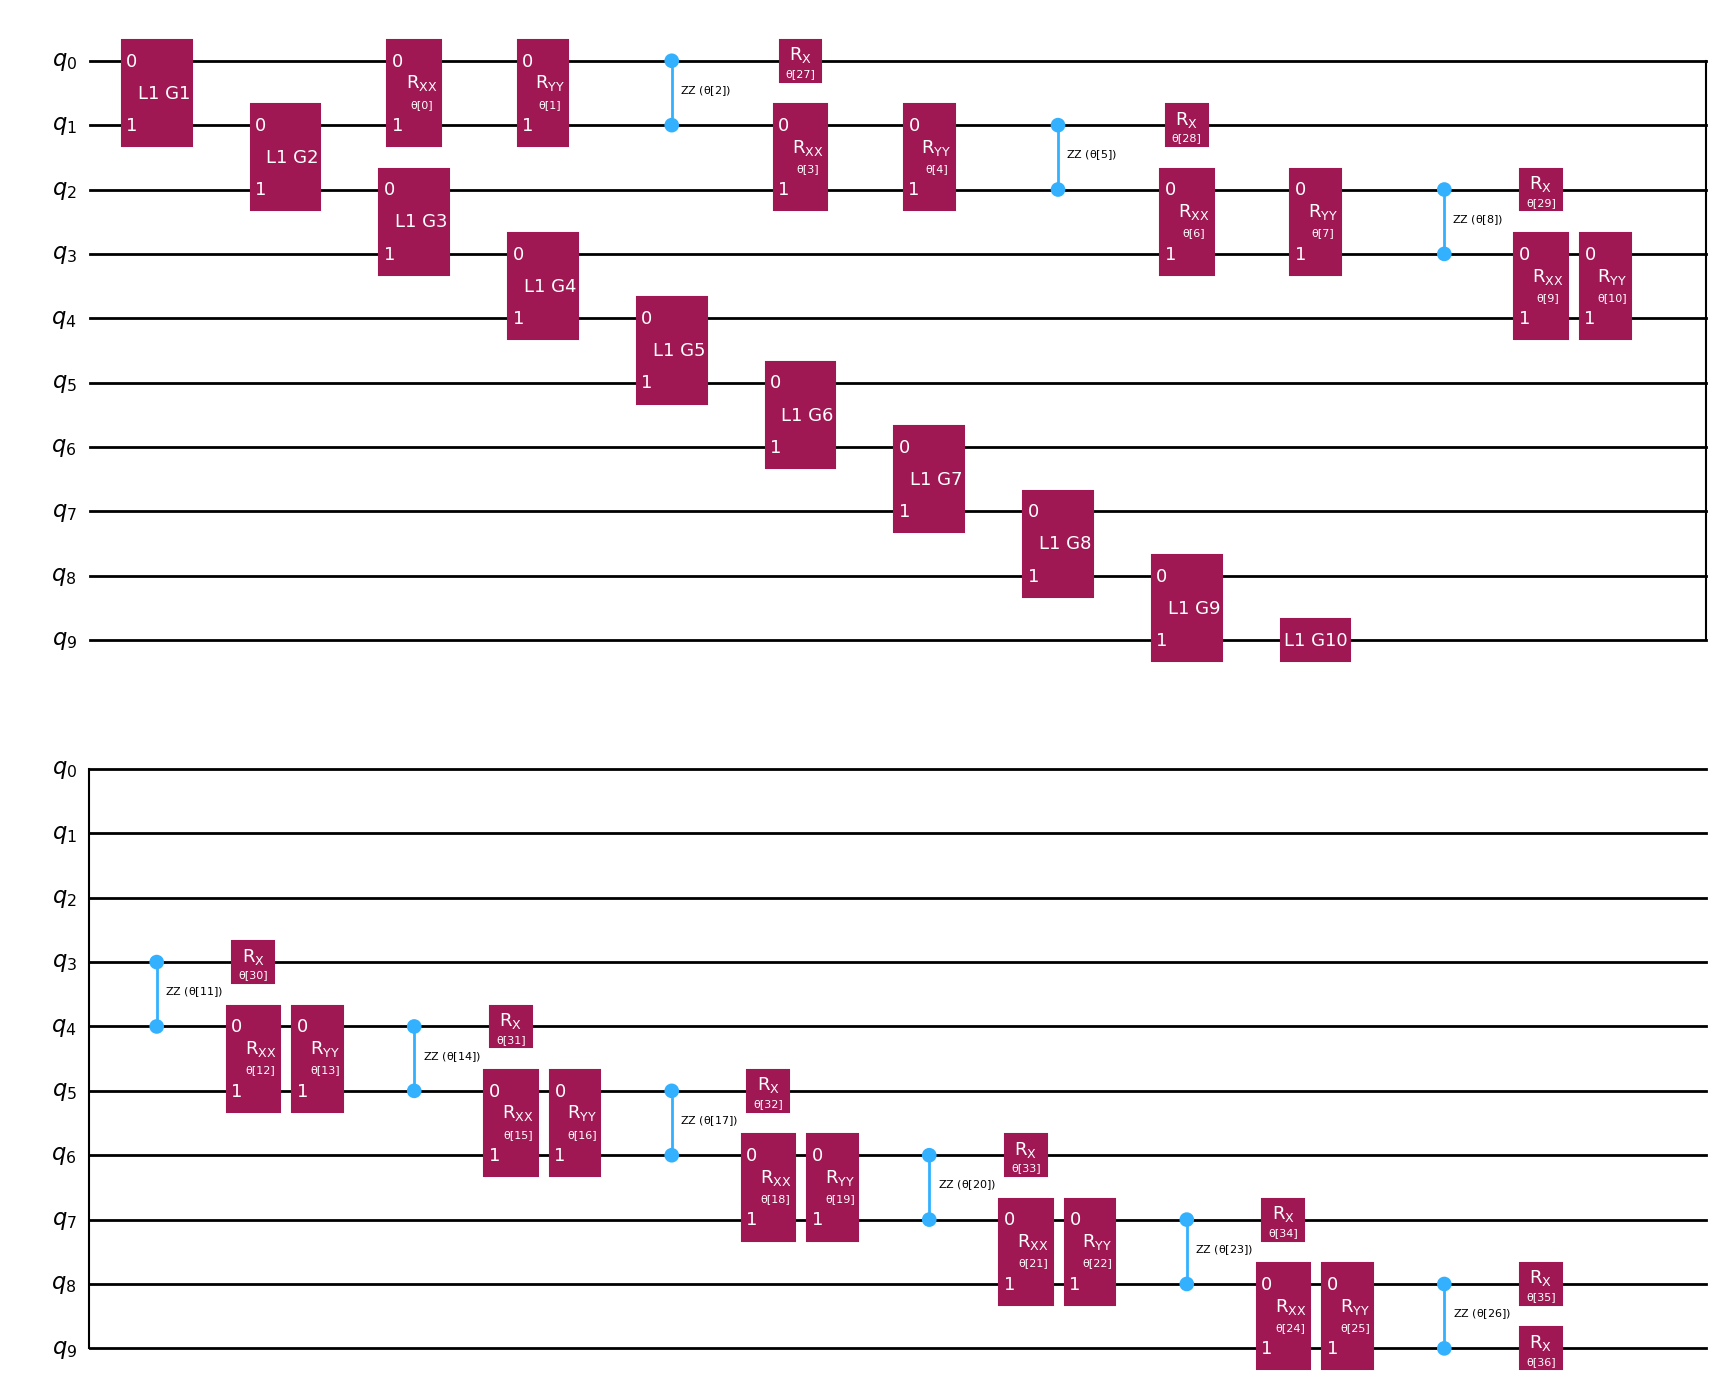

In [231]:
Nx, Ny = 2, 5
n_qubits = qc.num_qubits
assert n_qubits == Nx * Ny

# Compute how many parameters per layer for the new tail:
#   each layer has 3*(n_qubits-1) two-qubit rotations + n_qubits single-qubit RX’s
params_per_layer = 3 * (n_qubits - 1) + n_qubits

# Keep the same “num_layers” name:
num_layers = 1

# Redefine theta to match the new total count:
theta = ParameterVector('θ', length=num_layers * params_per_layer)

ansatz = QuantumCircuit(n_qubits)
idx = 0

for layer in range(num_layers):
    # (a) Two-qubit RXX, RYY, RZZ on each adjacent pair (q, q+1)
    for q in range(n_qubits - 1):
        ansatz.append(RXXGate(theta[idx]), [q, q + 1])
        idx += 1
        ansatz.append(RYYGate(theta[idx]), [q, q + 1])
        idx += 1
        ansatz.append(RZZGate(theta[idx]), [q, q + 1])
        idx += 1

    # (b) Single-qubit RX on each qubit
    for q in range(n_qubits):
        ansatz.rx(theta[idx], q)
        idx += 1

# Compose this variational tail onto the base qc
full_circ = qc.compose(ansatz, inplace=False)
full_circ.draw("mpl")

### Multiple depth VQE

In [180]:
records = []
for (D, p), qc in augmented_circuits.items():
    n_qubits = qc.num_qubits

    
    H_mat = (hamiltonian 
         if isinstance(hamiltonian, np.ndarray) 
         else Operator(hamiltonian).data)

    
    params = [param for param in qc.parameters
              if param.name.startswith(f"ϕ_D{D}_p{p}_")]
    #init_vals = np.zeros(len(params))
    init_vals = np.ones(len(params))
    #init_vals = 2 * np.pi * np.random.random(len(params))
    
    def energy_fn(x, qc=qc, params=params, H=H_mat):
        bound = qc.assign_parameters({p:v for p,v in zip(params, x)}, inplace=False)
        psi   = Statevector(bound).data
        return float(np.real(np.vdot(psi, H.dot(psi))))

    res = minimize(energy_fn, init_vals, method='COBYLA')
    pct_err = abs((res.fun - groundstate_value)/groundstate_value)*100
    energy = res.fun
    records.append({
      'qubits':   n_qubits,
      'MPS_depth':D,
      'var_depth':p,
      'pct_error':pct_err,
      'Energy':energy
    })
df = pd.DataFrame(records)

In [182]:
df = pd.DataFrame(records)
df = df.sort_values(['MPS_depth','var_depth']).reset_index(drop=True)
print(df.to_string(index=False))

 qubits  MPS_depth  var_depth  pct_error    Energy
     10          1          1   7.710318 -5.026753
     10          1          2  13.719388 -4.699456
     10          1          3  15.892887 -4.581072
     10          1          4  18.912253 -4.416616
     10          1          5  31.908997 -3.708721
     10          1          6  32.851349 -3.657394
     10          1          7  39.967275 -3.269810
     10          1          8  40.495556 -3.241036
     10          2          1   9.846665 -4.910393
     10          2          2  14.368739 -4.664088
     10          2          3  23.098457 -4.188606
     10          2          4  19.153338 -4.403485
     10          2          5  37.471426 -3.405751
     10          2          6  28.771354 -3.879619
     10          2          7  38.827517 -3.331889
     10          2          8  38.502882 -3.349571
     10          3          1   7.967501 -5.012745
     10          3          2   8.330457 -4.992976
     10          3          3  

Lowest error = 3.8446% at MPS_depth=9, var_depth=1


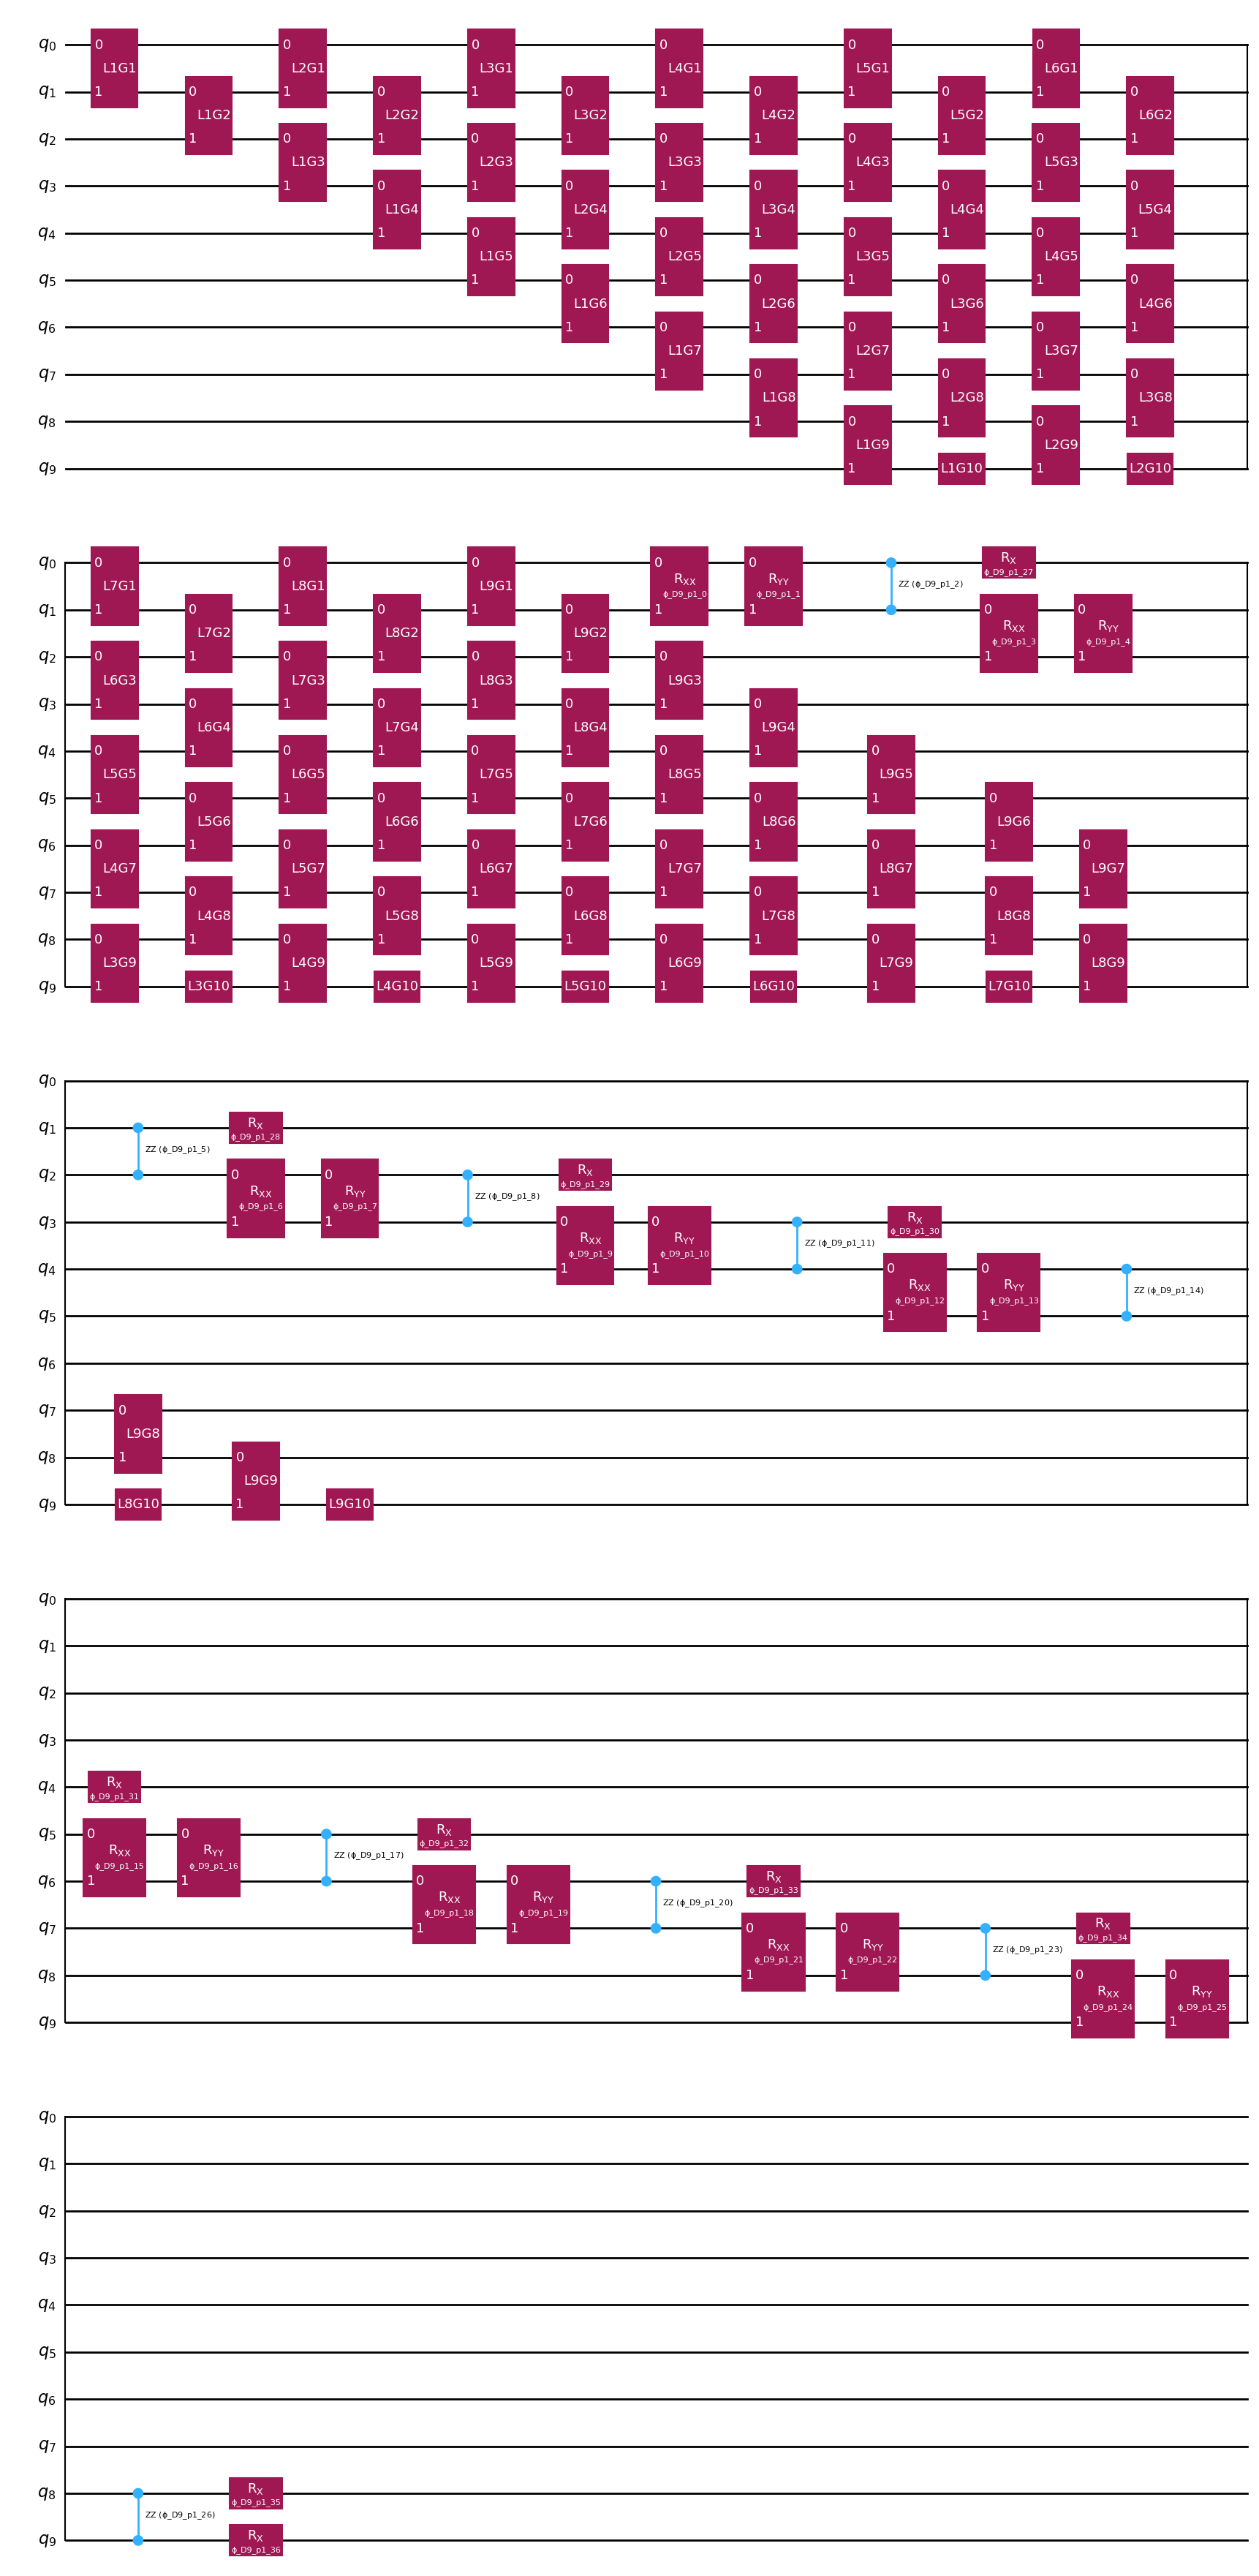

In [183]:
best_idx  = df['pct_error'].idxmin()
best_row  = df.loc[best_idx]
D_best    = int(best_row['MPS_depth'])
p_best    = int(best_row['var_depth'])
err_best  = best_row['pct_error']

print(f"Lowest error = {err_best:.4f}% at MPS_depth={D_best}, var_depth={p_best}")

best_circ = augmented_circuits[(D_best, p_best)]

best_circ.draw('mpl')

### Error Landscape

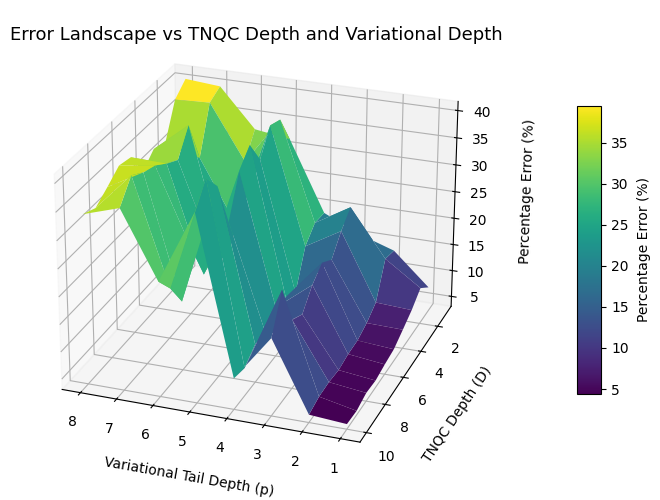

In [244]:
import numpy as np
import matplotlib.pyplot as plt

# your pivot
pivot = df.pivot(index='MPS_depth', columns='var_depth', values='pct_error')

# meshgrid for surface plot
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values

# create a larger figure
fig = plt.figure(figsize=(9, 6))
ax  = fig.add_subplot(111, projection='3d')

# surface with viridis colormap
surf = ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    edgecolor='none'
)

# axis labels with extra labelpad on z
ax.set_xlabel('Variational Tail Depth (p)', labelpad=10)
ax.set_ylabel('TNQC Depth (D)',        labelpad=10)
ax.set_zlabel('Percentage Error (%)',  labelpad=15)  # push it away from the plot

# title
ax.set_title('Error Landscape vs TNQC Depth and Variational Depth', fontsize=13, y=1.0)

# colorbar with a bit more pad on the left
cbar = fig.colorbar(
    surf, 
    ax=ax,
    shrink=0.6,
    aspect=12,
    pad=0.12,                # move it out to the right
    #label='Percentage Error (%)'
)
cbar.ax.set_ylabel('Percentage Error (%)', rotation=90, labelpad=6)

# adjust the overall subplot so labels don't overlap
fig.subplots_adjust(
    left=0.10, 
    right=0.85, 
    bottom=0.10, 
    top=0.90
)

# a better viewing angle
ax.view_init(elev=25, azim=110)

plt.show()

### Base layer visualisation

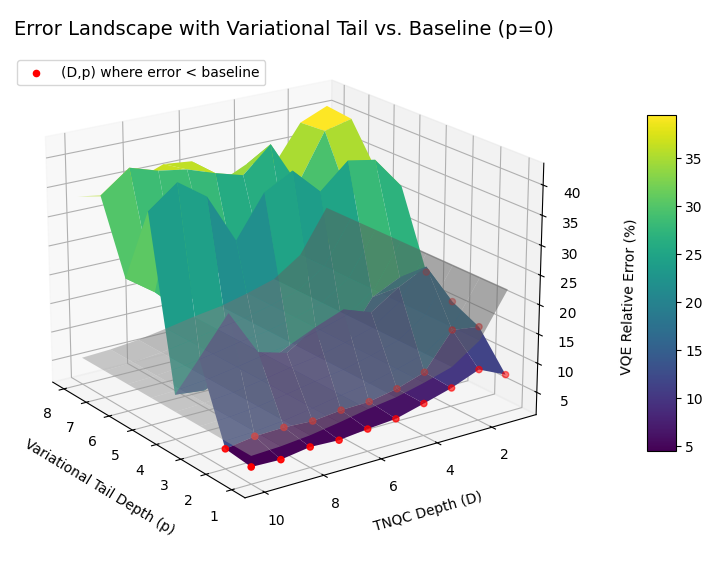

In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- (Re-use your existing 'records' list, DataFrame, and pivot step) ---
df = pd.DataFrame(records)
df = df.sort_values(['MPS_depth', 'var_depth']).reset_index(drop=True)

# Create pivot for the full (D,p) surface
pivot = df.pivot(index='MPS_depth', columns='var_depth', values='pct_error')

# Meshgrid for plotting (X = variational depth p, Y = TNQC depth D)
X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
Z = pivot.values  # shape (10,10): rows → D=1..10, cols → p=1..10

# --- Baseline errors for p=0, D=1..10 (as provided) ---
baseline_errors = np.array([
22.27951829034923,
14.831292266993316,
11.56160622606134,
10.148661737857307,
8.967695132703373,
8.25920807826765,
7.346819951697975,
6.551801367217654,
6.061922843741386,
5.828274651932926
])  # shape (10,)

# Tile the baseline so that for each D (row) it is constant across all p (columns)
baseline_Z = np.tile(baseline_errors[:, np.newaxis], (1, pivot.columns.size))
# baseline_Z is shape (10,10), with each row i = baseline_errors[i] repeated

# Compute a boolean mask: True wherever the full surface Z lies BELOW the baseline
improve_mask = (Z < baseline_Z)
# … everything up through computing improve_mask … #

# Flattened coordinates where improvement occurs
xs = X[improve_mask]
ys = Y[improve_mask]
zs = Z[improve_mask]     # ← use the actual surface height here

# --- Plot both surfaces plus red dots on the error surface ---
fig = plt.figure(figsize=(10, 7))
ax  = fig.add_subplot(111, projection='3d')

# 1) Main error surface
surf = ax.plot_surface(
    X, Y, Z,
    cmap='viridis',
    edgecolor='none',
    linewidth=0,
    antialiased=True
)

# 2) Baseline surface (for reference)
baseline_surf = ax.plot_surface(
    X, Y, baseline_Z,
    color='lightgray',
    alpha=0.5,
    edgecolor='none'
)

# 3) Red dots on the **error** surface wherever Z < baseline_Z
ax.scatter(
    xs, ys, zs,
    color='red',
    s=20,
    #edgecolors='none',
    label='(D,p) where error < baseline'
)

# Labels, legend, colorbar, view, etc.
ax.set_xlabel('Variational Tail Depth (p)', labelpad=10)
ax.set_ylabel('TNQC Depth (D)',        labelpad=10)
ax.set_zlabel('VQE Relative Error (%)',labelpad=15)

ax.set_title('Error Landscape with Variational Tail vs. Baseline (p=0)', fontsize=14, y=1.02)
ax.legend(loc='upper left', bbox_to_anchor=(0, 0.92))

cbar = fig.colorbar(
    surf,
    ax=ax,
    shrink=0.6,
    aspect=12,
    pad=0.12,
)
ax.view_init(elev=20, azim=145)
fig.subplots_adjust(left=0.10, right=0.85, bottom=0.10, top=0.90)

plt.show()


### single circuit

In [232]:
def energy(theta_vals):
    
    param_dict = {theta[i]: theta_vals[i] for i in range(len(theta))}
    bound = full_circ.assign_parameters(param_dict, inplace=False)

    state = Statevector(bound)
    vec = state.data 


    H_mat = Operator(hamiltonian).data
    return np.real(np.vdot(vec, H_mat.dot(vec)))

init_params = np.ones(len(theta))

energies_truncated = []

def record_energy(xk):
    energies_truncated.append(energy(xk))  
res = minimize(energy, init_params, method='L-BFGS-B', callback=record_energy)
opt_params = res.x

if 'groundstate_value' in globals():
    print("Energy of TNQC:", np.real(Energy))
    print("Energy of initial guess:", np.real(energies[0]))
    print(f"Optimized energy: {res.fun:.8f}")
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage Error (%): {(np.abs((res.fun - groundstate_value) / groundstate_value) * 100)}")



Energy of TNQC: -4.47889553709418
Energy of initial guess: -2.9543455875997573
Optimized energy: -4.86401460
Exact ground-state energy: -5.44671206
Energy error: 5.83e-01
Percentage Error (%): 10.698150766829219


### Energy Convergence

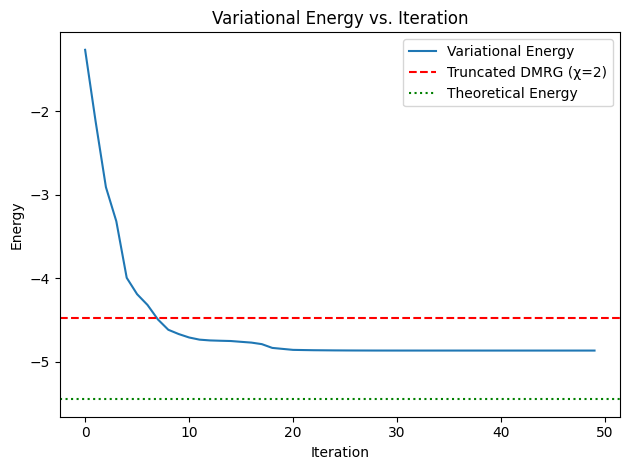

In [233]:
import matplotlib.pyplot as plt

# ... (after your optimization loop)

# Define the reference energies
dmrg_energy   = -4.478895537956847 
theo_energy   = -5.446712000714032

plt.figure()
plt.plot(energies_truncated, label='Variational Energy')

# Add horizontal lines
plt.axhline(y=dmrg_energy,
            color='r', linestyle='--',
            label=f'Truncated DMRG (χ=2)')
plt.axhline(y=theo_energy,
            color='g', linestyle=':',
            label=f'Theoretical Energy')

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Variational Energy vs. Iteration')
plt.legend()
plt.tight_layout()
plt.show()

# Qiskit Ansatz

### Hardware Efficient

Initial energy (θ = init_vals): -2.95434559
Optimized energy: -4.25747717
Exact ground-state energy: -5.44671206
Energy error: 1.19e+00
Percentage error (%): 21.8340


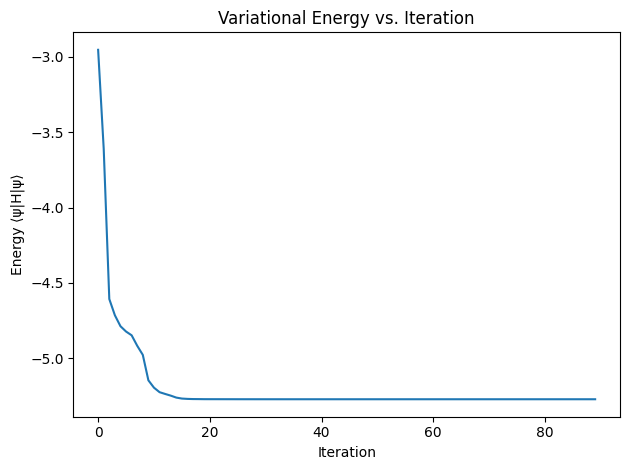

In [222]:
n_qubits = hamiltonian.num_qubits  
qc = EfficientSU2(num_qubits=n_qubits, reps=1)

qc.decompose().draw(output="mpl", style="iqp")


params = list(qc.parameters) 
num_params = len(params)


def energy(param_vals):
    
    bound_circ = qc.assign_parameters(
        {p: v for p, v in zip(params, param_vals)},
        inplace=False
    )
    
    psi = Statevector.from_instruction(bound_circ).data

    
    if isinstance(hamiltonian, np.ndarray):
        H_mat = hamiltonian
    else:
        H_mat = Operator(hamiltonian).data

    return np.real(np.vdot(psi, H_mat.dot(psi)))



init_vals = np.ones(num_params)

energies_SU2 = []

def record_energy(xk):

    energies_SU2.append(energy(xk))



res = minimize(
    fun=energy,
    x0=init_vals,
    method='L-BFGS-B',
    callback=record_energy,
    options={
        'maxiter': 2000,
        'ftol': 1e-6,
        'disp': True
    }
)

opt_vals = res.x 


print(f"Initial energy (θ = init_vals): {energies[0]:.8f}")
print(f"Optimized energy: {res.fun:.8f}")
if 'groundstate_value' in globals():
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage error (%): {np.abs((res.fun - groundstate_value) / groundstate_value) * 100:.4f}")

plt.figure()
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy ⟨ψ|H|ψ⟩')
plt.title('Variational Energy vs. Iteration')
plt.tight_layout()
plt.show()

### Chem-Inspired

Initial energy (θ = init_vals): -2.95434559
Optimized energy: -4.25747814
Exact ground-state energy: -5.44671206
Energy error: 1.19e+00
Percentage error (%): 21.8340


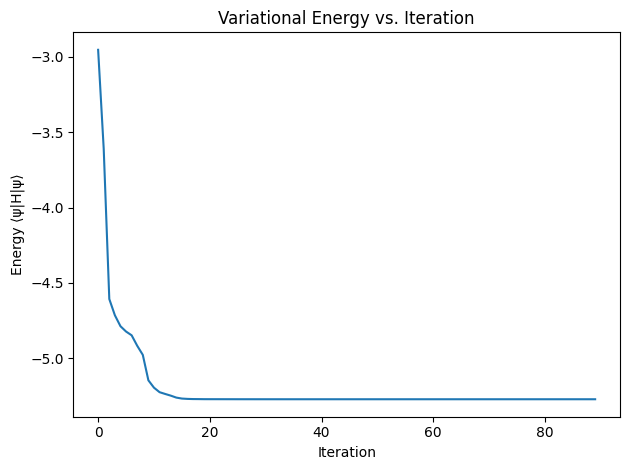

In [223]:
n_qubits = hamiltonian.num_qubits  
qc = TwoLocal(
    num_qubits=10,
    rotation_blocks=["ry"],       # like single-excitation rotations
    entanglement_blocks=["cx"],   # like hopping terms
    entanglement="linear",
    reps=1
)

qc.decompose().draw(output="mpl", style="iqp")


params = list(qc.parameters) 
num_params = len(params)


def energy(param_vals):
    
    bound_circ = qc.assign_parameters(
        {p: v for p, v in zip(params, param_vals)},
        inplace=False
    )
    
    psi = Statevector.from_instruction(bound_circ).data

    
    if isinstance(hamiltonian, np.ndarray):
        H_mat = hamiltonian
    else:
        H_mat = Operator(hamiltonian).data

    return np.real(np.vdot(psi, H_mat.dot(psi)))



init_vals = np.ones(num_params)

energies_UCCSD = []

def record_energy(xk):

    energies_UCCSD.append(energy(xk))



res = minimize(
    fun=energy,
    x0=init_vals,
    method='L-BFGS-B',
    callback=record_energy,
    options={
        'maxiter': 2000,
        'ftol': 1e-6,
        'disp': True
    }
)

opt_vals = res.x 


print(f"Initial energy (θ = init_vals): {energies[0]:.8f}")
print(f"Optimized energy: {res.fun:.8f}")
if 'groundstate_value' in globals():
    print(f"Exact ground-state energy: {groundstate_value:.8f}")
    print(f"Energy error: {res.fun - groundstate_value:.2e}")
    print(f"Percentage error (%): {np.abs((res.fun - groundstate_value) / groundstate_value) * 100:.4f}")

plt.figure()
plt.plot(energies)
plt.xlabel('Iteration')
plt.ylabel('Energy ⟨ψ|H|ψ⟩')
plt.title('Variational Energy vs. Iteration')
plt.tight_layout()
plt.show()

# Convergence Plots 

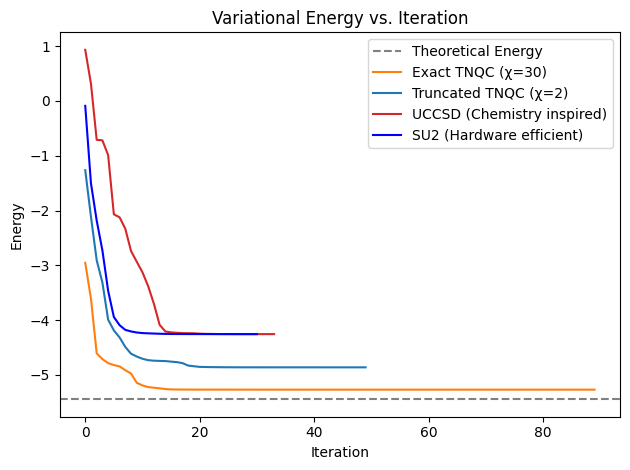

In [241]:
plt.figure()

# Theoretical energy line
theo_energy = -5.446712000714032
plt.axhline(
    y=theo_energy,
    color='gray',
    linestyle='--',
    label='Theoretical Energy'
)

# Convergence curves with explicit colors and labels
plt.plot(
    energies_exact,
    color='tab:Orange',
    label='Exact TNQC (χ=30)')

plt.plot(
    energies_truncated,
    color='tab:blue',
    label='Truncated TNQC (χ=2)'
)
plt.plot(
    energies_UCCSD,
    color='tab:Red',
    label='UCCSD (Chemistry inspired)'
)
plt.plot(
    energies_SU2,
    color='b',
    label='SU2 (Hardware efficient)'
)

plt.xlabel('Iteration')
plt.ylabel('Energy')
plt.title('Variational Energy vs. Iteration')
plt.legend()
plt.tight_layout()
plt.show()
